In [53]:
data_dir = "/home/kareem/hacking/research/AI_Love/denoising/CNN_TASK"

In [54]:
device = "cuda"

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

## Prepare the Images 
1. normalize the pixel range of the images  to 0-1 
2. 256x256 pixel 

In [56]:
import torchvision.datasets as datasets
dataset = datasets.ImageFolder(data_dir)

In [57]:
dataset

Dataset ImageFolder
    Number of datapoints: 3
    Root location: /home/kareem/hacking/research/AI_Love/denoising/CNN_TASK

In [76]:
from torchvision import transforms


data_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        # transforms.Normalize(
        #     mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        # ),  # Normalize channels to [-1, 1]
    ]
)

In [89]:
free_noise = "/home/kareem/hacking/research/AI_Love/denoising/Simulated_data_sennd/Noise_free/image_0102.jpg"
from PIL import Image
free_noise= Image.open(free_noise)
free_noise = data_transforms(free_noise)
free_noise = free_noise.to(device)
free_noise.shape

torch.Size([3, 256, 256])

In [90]:
dataset = datasets.ImageFolder(data_dir,transform=data_transforms)

In [91]:
dataset

Dataset ImageFolder
    Number of datapoints: 3
    Root location: /home/kareem/hacking/research/AI_Love/denoising/CNN_TASK
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [92]:
clean_img = dataset[0]
t_image, label = clean_img
t_image.shape, label

(torch.Size([3, 256, 256]), 0)

In [93]:
t_image = t_image.unsqueeze(0)
t_image.shape

torch.Size([1, 3, 256, 256])

In [94]:
t_image = t_image.to(device)

In [95]:
class network(nn.Module):
    def __init__(self,n_chan,chan_embed=48):
        super(network,self).__init__()

        self.act = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        self.conv1 = nn.Conv2d(n_chan,chan_embed,3,padding=1)
        self.covn2 = nn.Conv2d(chan_embed,chan_embed,3,padding=1)
        self.conv3 = nn.Conv2d(chan_embed,n_chan,1)
    def forward(self,x):
        x = self.act(self.conv1(x))
        x = self.act(self.covn2(x))
        x = self.conv3(x)

        return x

n_chan = t_image.shape[1]
model = network(n_chan)
model = model.to(device)
print(
    "The number of parameters of the network is: ",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

The number of parameters of the network is:  22275


In [96]:
def pair_downsampler(img):
    # img has shape B C H W
    c = img.shape[1]

    filter1 = torch.FloatTensor([[[[0, 0.5], [0.5, 0]]]]).to(img.device)
    filter1 = filter1.repeat(c, 1, 1, 1)

    filter2 = torch.FloatTensor([[[[0.5, 0], [0, 0.5]]]]).to(img.device)
    filter2 = filter2.repeat(c, 1, 1, 1)

    output1 = F.conv2d(img, filter1, stride=2, groups=c)
    output2 = F.conv2d(img, filter2, stride=2, groups=c)

    return output1, output2

In [97]:
t_image.shape

torch.Size([1, 3, 256, 256])

Text(0.5, 1.0, 'Second downsampled')

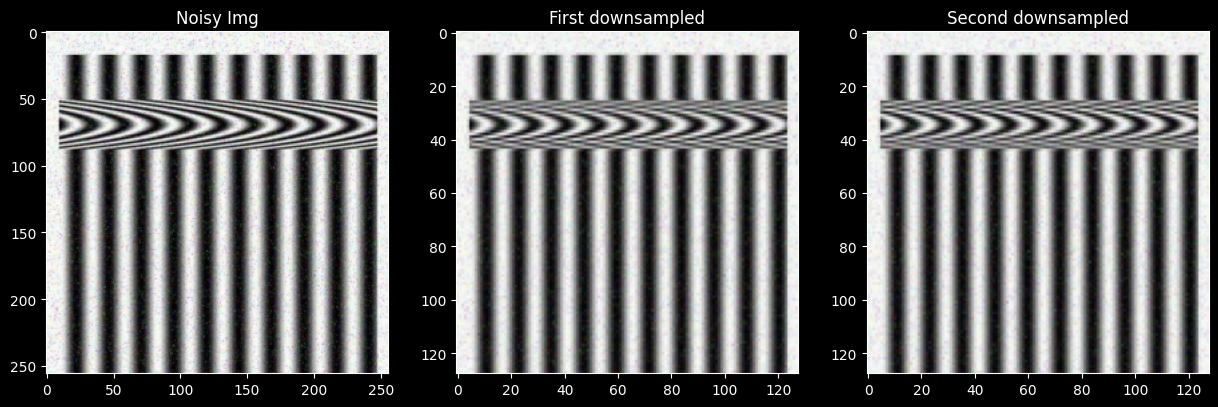

In [98]:
img1, img2 = pair_downsampler(t_image)

img0 = t_image.cpu().squeeze(0).permute(1, 2, 0)
img1 = img1.cpu().squeeze(0).permute(1, 2, 0)
img2 = img2.cpu().squeeze(0).permute(1, 2, 0)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(img0)
ax[0].set_title("Noisy Img")

ax[1].imshow(img1)
ax[1].set_title("First downsampled")

ax[2].imshow(img2)
ax[2].set_title("Second downsampled")

In [99]:
def mse(gt: torch.Tensor, pred: torch.Tensor) -> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt, pred)


def loss_func(noisy_img):
    noisy1, noisy2 = pair_downsampler(noisy_img)

    pred1 = noisy1 - model(noisy1)
    pred2 = noisy2 - model(noisy2)

    loss_res = 1 / 2 * (mse(noisy1, pred2) + mse(noisy2, pred1))

    noisy_denoised = noisy_img - model(noisy_img)
    denoised1, denoised2 = pair_downsampler(noisy_denoised)

    loss_cons = 1 / 2 * (mse(pred1, denoised1) + mse(pred2, denoised2))

    loss = loss_res + loss_cons

    return loss

In [100]:
def train(model, optimizer, noisy_img):

    loss = loss_func(noisy_img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def test(model, noisy_img, clean_img):

    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img), 0, 1)
        MSE = mse(clean_img, pred).item()
        PSNR = 10 * np.log10(1 / MSE)

    return PSNR


def denoise(model, noisy_img):

    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img), 0, 1)

    return pred

In [101]:
max_epoch = 3000  # training epochs
lr = 0.001  # learning rate
step_size = 1000  # number of epochs at which learning rate decays
gamma = 0.5  # factor by which learning rate decays

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [102]:
for epoch in tqdm(range(max_epoch)):
    train(model, optimizer, t_image)
    scheduler.step()

  0%|          | 0/3000 [00:00<?, ?it/s]

In [104]:
dataset[0][1]

0

In [105]:
free_noise = free_noise.to(device)

In [106]:
PSNR = test(model, t_image, free_noise)
print(PSNR)

27.755394893932067


/home/kareem/mambaforge/envs/dinov2/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [107]:
denoised_img = denoise(model,t_image)

denoised = denoised_img.cpu().squeeze(0).permute(1,2,0)
clean = free_noise.cpu().squeeze(0).permute(1,2,0)
noisy = t_image.cpu().squeeze(0).permute(1,2,0)

/home/kareem/mambaforge/envs/dinov2/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3, 256, 256])) that is different to the input size (torch.Size([1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Text(0.5, 0, '27.76 dB')]

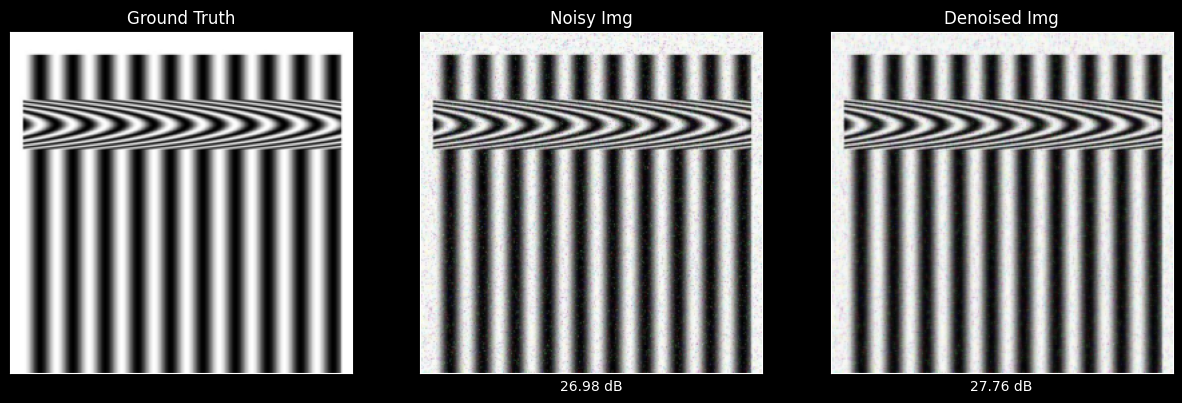

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(clean)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Ground Truth")

ax[1].imshow(noisy)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Noisy Img")
noisy_psnr = 10 * np.log10(1 / mse(t_image, free_noise).item())
ax[1].set(xlabel=str(round(noisy_psnr, 2)) + " dB")

ax[2].imshow(denoised)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title("Denoised Img")
ax[2].set(xlabel=str(round(PSNR, 2)) + " dB")